#### Import Libraries

In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

#### Load dataset

In [20]:
directory = 'Data/segmented_trips'
d = []

for file_name in os.listdir(directory):
    if file_name.startswith('Merchants_Segments') and file_name.endswith('.json'):
        month = int(file_name.split('_')[2][:2])  # Extract the month and convert to int
        
        file_path = os.path.join(directory, file_name)  
        with open(file_path, 'r') as file:
            for line in file:  
                entry = json.loads(line)  
                entry['month'] = month  # Add month to the data
                d.append(entry) 


data = pd.DataFrame(d)

In [21]:
# Load pooling files
directory = 'Data/careems_data'
dp = []

# Loop through all pooling files 
for file_name in os.listdir(directory):
    if file_name.startswith('anon_pooling') and file_name.endswith('.csv'):  # Check file name and extension
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)  
        dp.append(df)  


df_pooling = pd.concat(dp, ignore_index=True)

#### Feature Engineering

In [22]:
df_pooling = df_pooling.rename(columns={'booking_id': 'trip_id'})  
data = pd.merge(data, df_pooling[['trip_id', 'food_preparation_time']], on='trip_id', how='left')

In [23]:
# Extract the first lat and lng as merchant coordinates
data['merchant_coords'] = list(zip(data['lats'].apply(lambda x: x[0]), data['lngs'].apply(lambda x: x[0])))

# Function to determine if a day is a weekday
def is_weekday(dateID):
    day_of_week = (dateID + 1) % 7  # Calculate day of the week (0=Sunday, 1=Monday, 2=Tuesday, 3=Wednesday, 4=Thursday, 5=Friday, 6=Saturday)
    # Return 1 for Thursday, Friday, Saturday (weekends in Jordan)
    return 1 if day_of_week in [4, 5, 6] else 0

data['weekday'] = data['dateID'].apply(is_weekday)

# Select and rename columns 
data = data[['trip_id', 'trip_time', 'driverID', 'timeID', 'dateID', 'weekday', 'merchant', 'merchant_coords', 'month','food_preparation_time']]
data = data.rename(columns={'trip_time': 'wait_time'})
data = data.rename(columns={'merchant': 'merchantID'})

In [24]:
# Converting 'timeID' to hours
data['hour'] = data['timeID'] // 60

# Calculate order frequency per hour for each merchant
order_frequency = data.groupby(['merchantID', 'hour', 'dateID', 'month']).size().reset_index(name='order_frequency_per_hour')

# Merge the order frequency data back to the original data on 'merchantid', 'hour', and 'dateID'
data = data.merge(order_frequency, on=['merchantID', 'hour', 'dateID', 'month'], how='left')

In [25]:
# Aassign time periods based on timeID
def assign_time_period(time_id):
    if 0 <= time_id < 360:         # Midnight to 6 AM
        return 'night'
    elif 360 <= time_id < 720:      # 6 AM to Noon
        return 'morning'
    elif 720 <= time_id < 1080:     # Noon to 6 PM
        return 'afternoon'
    else:                           # 6 PM to Midnight
        return 'evening'

# Apply the function to create a new 'time_period' feature
data['time_period'] = data['timeID'].apply(assign_time_period)

# Option 1: Convert 'time_period' to ordinal integers
time_period_mapping = {'night': 0, 'morning': 1, 'afternoon': 2, 'evening': 3}
data['time_period'] = data['time_period'].map(time_period_mapping)


In [26]:
# Creating interaction terms 
data['order_weekday_interaction'] = data['order_frequency_per_hour'] * data['weekday']
data['time_period_order_freq'] = data['time_period'] * data['order_frequency_per_hour']

In [27]:
center_lat, center_lon = 31.96316667, 35.93036111  # downtown Amman

# Separate 'merchant_coords' into 'merchant_lat' and 'merchant_lon'
data[['merchant_lat', 'merchant_lon']] = pd.DataFrame(data['merchant_coords'].tolist(), index=data.index)

data['merchant_distance_from_center'] = np.sqrt((data['merchant_lat'] - center_lat)**2 + (data['merchant_lon'] - center_lon)**2)

# Drop the 'merchant_lat' and 'merchant_lon' columns
data = data.drop(columns=['merchant_lat', 'merchant_lon'])

In [28]:
# Target encoding merchant and driver
data['merchantID_encoded'] = data.groupby('merchantID')['wait_time'].transform('mean')
data['driverID_encoded'] = data.groupby('driverID')['wait_time'].transform('mean')

In [29]:
# Remove trips with wait time longer than 50 minutes
data = data[data['wait_time'] <= 3000]

In [30]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 280571 entries, 0 to 280668
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   trip_id                        280571 non-null  object 
 1   wait_time                      280571 non-null  float64
 2   driverID                       280571 non-null  object 
 3   timeID                         280571 non-null  int64  
 4   dateID                         280571 non-null  int64  
 5   weekday                        280571 non-null  int64  
 6   merchantID                     280571 non-null  object 
 7   merchant_coords                280571 non-null  object 
 8   month                          280571 non-null  int64  
 9   food_preparation_time          280571 non-null  float64
 10  hour                           280571 non-null  int64  
 11  order_frequency_per_hour       280571 non-null  int64  
 12  time_period                    2805

#### Train/Test Split

In [31]:
feature_columns = ['order_frequency_per_hour', 'merchantID_encoded', 'driverID_encoded', 'order_weekday_interaction','food_preparation_time','time_period', 'merchant_distance_from_center'] 
target_column = 'wait_time'

X = data[feature_columns]
y = data[target_column]
trip_ids = data['trip_id']

# Split the dataset into training and testing 
X_train, X_test, y_train, y_test, trip_ids_train, trip_ids_test = train_test_split(X, y, trip_ids, test_size=0.2, random_state=42)

#### Feature correlation

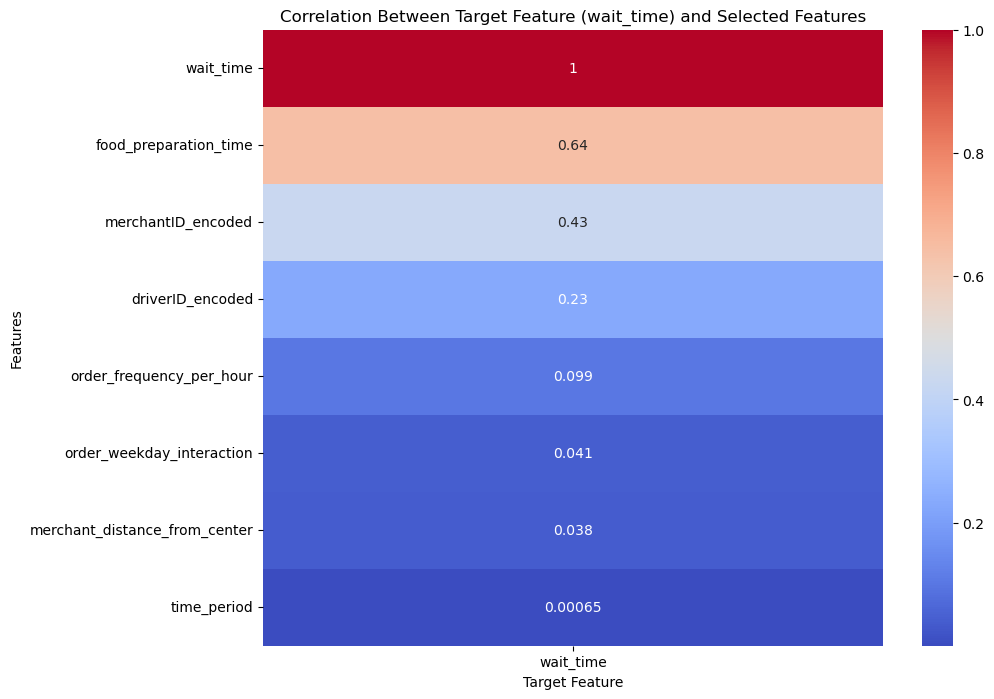

In [32]:
#Feature correlation
selected_columns = feature_columns + [target_column]
data_selected = data[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = data_selected.corr()

# Plot the correlation between the target feature and other features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[[target_column]].sort_values(by=target_column, ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation Between Target Feature (wait_time) and Selected Features")
plt.xlabel("Target Feature")
plt.ylabel("Features")
plt.show()

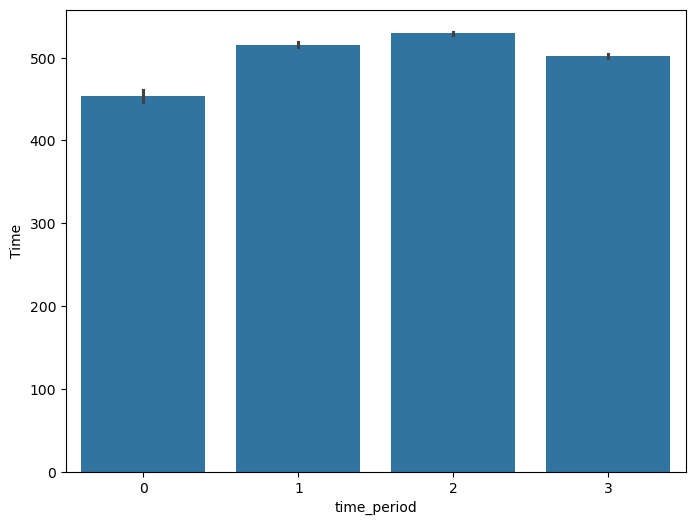

In [33]:
# Relationship between time_period and wait_time

# Assuming 'weekend' is a boolean column and 'time' is the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x='time_period', y='wait_time', data=data)
# plt.title('Box Plot of Time by Weekend')
plt.xlabel('time_period')
plt.ylabel('Time')
plt.show()


#### XGBoost

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import root_mean_squared_error

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=1500,              
    learning_rate=0.005,             
    max_depth=6,                   
    random_state=42,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.5,
    reg_lambda=1,   
    subsample=0.6
)


# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) 


print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Root Mean Squared Error (RMSE): 249.9181089687447
Mean Absolute Error (MAE): 186.12380074565024
R-Squared (R2): 0.5376861131567614
Mean Absolute Percentage Error (MAPE): 0.5363218156930553


In [35]:
actual_vs_predicted_df = pd.DataFrame({
    'trip_id': trip_ids_test, 
    'actual_eta': y_test,
    'predicted_eta': y_pred
})

output_file_path = 'Model Predictions/xgboost_predictions.csv'
actual_vs_predicted_df.to_csv(output_file_path, index=False)

print(f"Predicted values saved to '{output_file_path}'")


Predicted values saved to 'Model Predictions/xgboost_predictions.csv'


##### feature importance

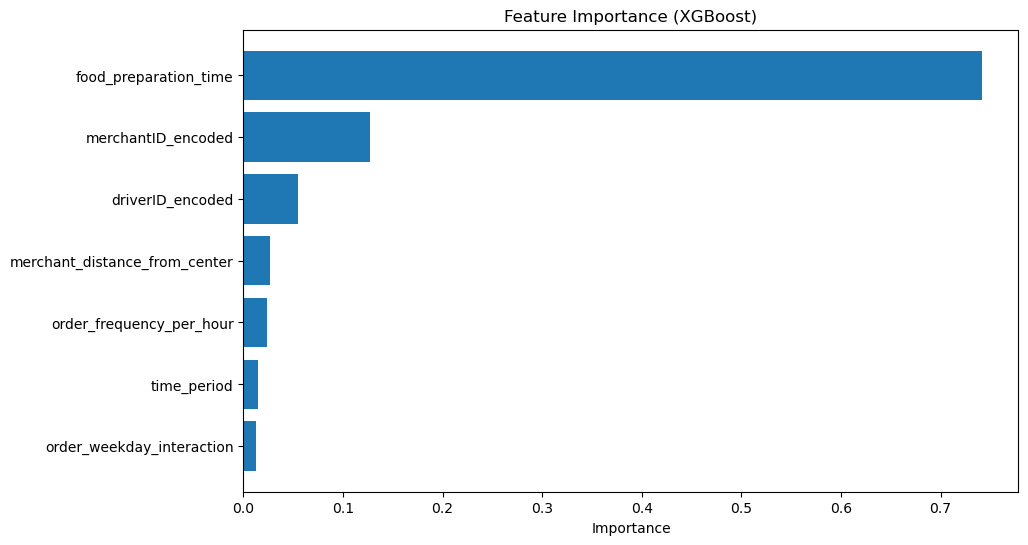

In [36]:
feature_importances = xgboost_model.feature_importances_
features = X_train.columns

# Create a DataFrame to sort and plot feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Optional: invert y-axis for descending order
plt.show()


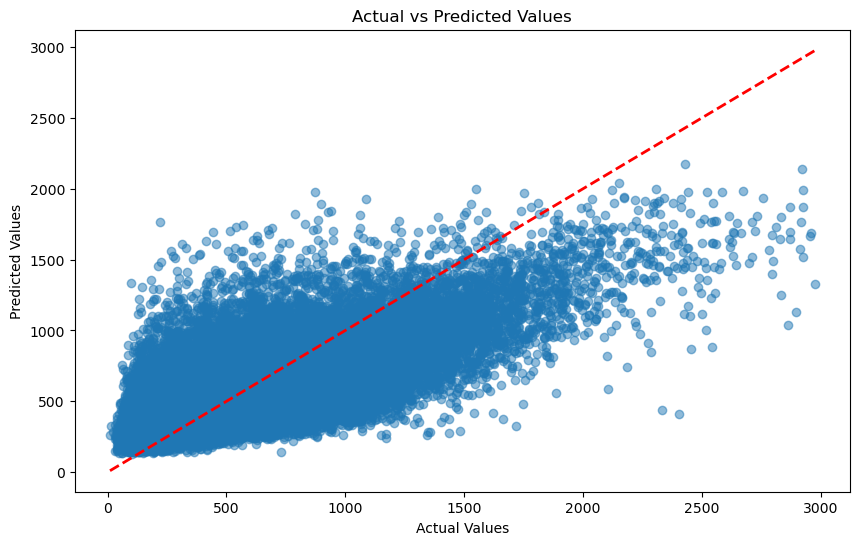

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


##### Parameter grid search

In [38]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3, 0.5],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }

# # Define a custom RMSE scorer
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Use the custom RMSE function with make_scorer
# scoring = make_scorer(rmse, greater_is_better=False)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgboost_model,
#     param_grid=param_grid,
#     scoring=scoring,    # Use 'accuracy' for classification tasks
#     cv=3,               # 3-fold cross-validation
#     verbose=1,
#     n_jobs=-1           # Use all available cores
# )

# # Fit GridSearchCV
# grid_search.fit(X, y)

# # Print the best parameters and best RMSE score
# print("Best Parameters:", grid_search.best_params_)
# print("Best RMSE Score:", -grid_search.best_score_)